In [1]:
%pylab

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


# Part I: Understanding the Data

In this course, you will be using gamma-ray interaction data generated by a Geant4 simulation to investigate gamma-ray imaging via the Compton modality. As with any data analysis task, the first step is to understand how to load and manipulate the data. This notebook is intended to provide you with background information about the generation and format of the data.

## Geant4 Simulation Parameters

It is important to have a clear idea of the "experiment" that was used to generate the data. We have modelled the gamma-ray imager after a planar HPGe imaging system known as the Volumetric Compton Imager (VCI): it consists of two square-faced planar HPGe detectors that are 74 mm wide and 15 mm thick. The two planar detectors are parallel and separated by a gap of 10 mm. Note that this simple model only contains the HPGe detectors and does not include any of the surrounding material (cryostat, front-ends, etc), so the simulation will not account for scattering effects outside of the detector volumes.

The figure below shows how the coordinate frame is defined for the simulation. The origin of the coordinate system is directly in the center of the two planar detectors, with the positive coordinate axes as shown in the figure.

The gamma-ray source used for the "experiment" models a point source of Cs-137, emitting gamma-rays with energy 661.657 keV from a point 2 meters in front of the front-face of the first detector (i.e. the source location is (0, 0, -2m) in the simulation coordinate frame).

<img src="simulation_geom.png">

## Simulation Data

The `README.md` has instructions for how to download the data we will be using for the course. If you have not yet downloaded the data, please run the following line:

In [ ]:
!wget -L -O hits.h5 https://www.dropbox.com/s/ojq4i9fyz8f7205/hits.h5?dl=0

The data is stored in an [HDF5](https://support.hdfgroup.org/HDF5/) archive whose format is detailed below. HDF5 is an extremely powerful tool for the storage and manipulation of scientific data, with libraries and APIs for many computing languages (in fact, the `.mat` files used for data storage in Matlab are actually `HDF5` files under the hood after version 7.3).

Don't worry if you don't have any experience with `HDF5`, this notebook will walk you through loading the data using `pytables`, a fantastic library with a high-level interface to `HDF5` archives.

In [2]:
# Import the pytables module
import tables

# Open the data archive in 'read' mode
hf = tables.open_file("hits.h5", "r")
print(hf)

hits.h5 (File) ''
Last modif.: 'Sun Sep 29 19:32:28 2019'
Object Tree: 
/ (RootGroup) ''
/EventLengths (EArray(201776,)) ''
/EventPointers (EArray(201776,)) ''
/InteractionData (Table(408395,)) ''



### Data Format

The `hits.h5` contains three items: a 1-D array of integers called `EventPointers`, a 1-D array of integers `EventLengths`, and a table of structured data called `InteractionData`. Each of these objects is attached to the *root* node of the file (i.e. the top-level file location). We don't have time to go into the details of `HDF5` or `pytables`, but we can load the events into memory as numpy arrays like so: 

In [3]:
event_pointers = hf.root.EventPointers.read()
event_lengths = hf.root.EventLengths.read()
idata = hf.root.InteractionData.read()

To understand how the data is composed, it is first necessary to understand the distinction between a gamma-ray **event** and a gamma-ray **interaction**.

A gamma-ray **interaction** describes a single physical process that the gamma-ray undergoes. Compton scattering, photoelectric absorption, and pair production are the three common ionizing gamma-ray interaction types of interest for gamma-ray spectroscopy and imaging. Each interaction is described by an 3D location where the interaction took place (in the coordinate frame shown above), as well as the energy deposited by the gamma-ray in the interaction.

A gamma-ray **event** consists of all of the interactions that are undergone by a particular gamma-ray as it passes through the detector. For example, a gamma-ray with incident energy of 1 MeV may interact with a detector by Compton scattering three times within the sensitive volume, and finally be absorbed via photoelectric absorption. The gamma-ray event is composed of the four interactions of the gamma-ray in the detector. Note that only interactions that occur within the sensitive volume of the detector are considered as part of the event!

Given these definitions, we can finally start working with the data. The `InteractionData` field contains information about individual interactions in the detector, while the `EventPointers` and `EventLengths` describe how the interactions are organized into events. Each value in the `EventPointers` is an integer that points to the index in the `InteractionData` array that indicates the start of an event. The corresponding value in the `EventLengths` array describes how many interactions constitute the event. The following cell gives an example of how to load the `n-th` event from the data arrays.

In [4]:
# Load the n-th event from data
n = 12
pointer = event_pointers[n]
length = event_lengths[n]
event = idata[pointer:pointer+length]
# Display the event
event

array([(314.26828, 1, -33.747643, -26.552032, 12.236414)],
      dtype=[('energy', '<f4'), ('trackId', '<i4'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4')])

# Exercises

The following questions are designed to help you familiarize yourself with the data in preparation for the gamam-ray event processing in the next lesson.

### How many events are in the current data set? What is the average number of gamma-ray interactions per event?

In [5]:
num_events=event_pointers.size
ave_events=average(event_lengths)
print(event_lengths.size)
print("number events= ",num_events,", average # interactions/event= ",ave_events)

201776
number events=  201776 , average # interactions/event=  2.0240018634525416


### Plot the distribution of the number of interactions per event.

<function matplotlib.pyplot.show(*args, **kw)>

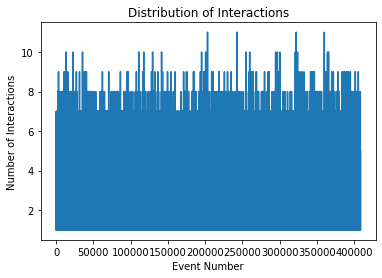

In [6]:
plt.title("Distribution of Interactions")
plt.xlabel("Event Number")
plt.ylabel("Number of Interactions")
plt.plot(event_pointers,event_lengths)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

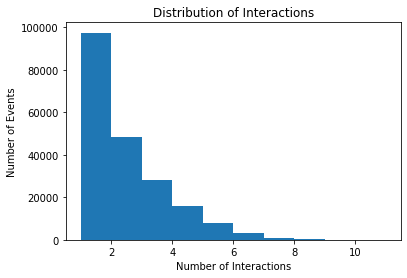

In [7]:
plt.title("Distribution of Interactions")
plt.xlabel("Number of Interactions")
plt.ylabel("Number of Events")
plt.hist(event_lengths)
plt.show

### Plot the energy spectrum of ALL the gamma-ray events.

<function matplotlib.pyplot.show(*args, **kw)>

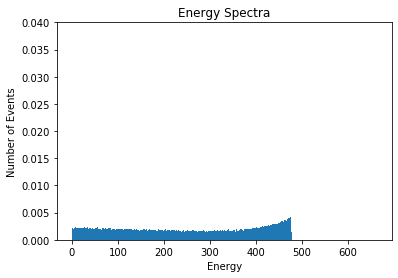

In [28]:
x=[]
# Load the n-th event from data
for n in range(0,event_pointers.size):
    pointer = event_pointers[n]
    length = event_lengths[n]
    event = idata[pointer:pointer+length]
    x.append(event['energy'].item(0))
plt.title("Energy Spectra")
plt.xlabel("Energy")
plt.ylabel("Number of Events")

binwidth=1
#plt.hist(x, bins=np.arange(min(x), max(x) + binwidth, binwidth),stacked='TRUE',density='TRUE')
plt.hist(x, bins=np.arange(min(x), max(x) + binwidth, binwidth),density='TRUE')
plt.ylim(0,0.04)
plt.show

### Create an array containing all of the gamma-ray events consisting of a single gamma-ray interaction. Repeat for the double-interaction and triple-interaction events.

In [31]:
# a mess but something like this should work
sing=[]
doub=[]
trip=[]
for n in range(0,event_pointers.size):
    pointer = event_pointers[n]
    length = event_lengths[n]
    event = idata[pointer:pointer+length]
    if event_lengths[n]==1:
        sing.append(event)
    if event_lengths[n]==2:
        doub.append(event)
    if event_lengths[n]==3:
        trip.append(event)

### In the same figure, plot the energy spectrum of the single-interaction, double-interaction, and triple-interaction events and compare each to the energy spectrum from all events